# Simple coupled ODE
## Make sure you install the libraries

## Execute the cells and the plots should be recreated


In [5]:
import deepxde as dde
import matplotlib.pyplot as plt
from deepxde.backend import torch 
import numpy as np 

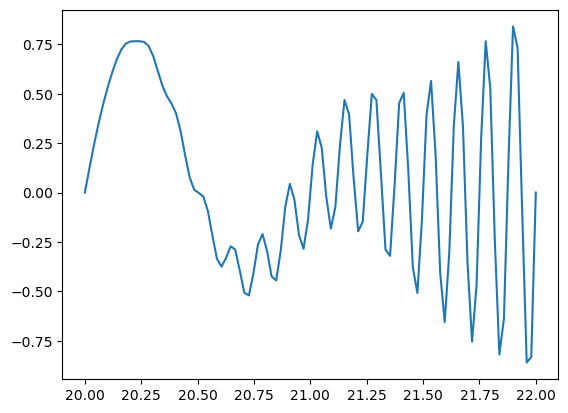

In [6]:
def pde(x,y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    f = -2*torch.pi*(22-x)*torch.cos(2*torch.pi*x)+0.5*torch.sin(2*torch.pi*x)-torch.pi**2*(22-x)**2*torch.sin(2*torch.pi*x) + \
     2*8*torch.pi*(x-20)*torch.cos(2*8*torch.pi*x)+0.5*torch.sin(2*8*torch.pi*x)-8**2*torch.pi**2*(x-20)**2*torch.sin(2*8*torch.pi*x)

    res = dy_xx - f
    return res 

def func(x):
    return ((22-x)**2/4)*(np.sin(2*np.pi*x))  +    ((x-20)**2/4)*(np.sin(16*np.pi*x))
def func_plot(x):
    return ((22-x)**2/4)*(np.sin(2*np.pi*x))  +    ((x-20)**2/4)*(np.sin(16*np.pi*x))
x = np.linspace(20,22,100)

u = func(x)
plt.plot(x,u)

In [7]:
def output_transform(x,y):
    res = 0.0
    for n in range(1,10):
        res = res + y[:,n-1:n]*torch.sin(n*np.pi*x)
    return res
def gauss_transform(x,y):
    res = 0.0
    for n in range(1,20):

        res = res + y[:,n-1:n]*torch.exp(-200*(x-0.05*n)*(x-0.05*n))
    return res

In [8]:
geom = dde.geometry.Interval(20, 22)


bc = dde.icbc.DirichletBC(geom, func, lambda _, on_boundary: on_boundary)
#ic_1 = dde.icbc.IC(geom, func, lambda _, on_initial: on_initial)

In [15]:
data = dde.data.PDE(
    geom,
    pde,
    [bc],
    num_domain=1000,
    num_boundary=360,
    
    solution=func,
    num_test=1000,
)

layer_size = [1] + [50] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(
    layer_size, activation, initializer
)
net.apply_feature_transform(lambda x: (x - 20)/2.0)
#net.apply_output_transform(output_transform)




layer_size_1 = [1] + [50] * 4 + [10]

net1 = dde.nn.FNN(
    layer_size_1, activation, initializer
)
net1.apply_feature_transform(lambda x: (x - 20)/2.0)
net1.apply_output_transform(output_transform)

In [16]:
model = dde.Model(data, net)

model.compile(
    "adam",
    lr=0.001,
    metrics=["l2 relative error"],
    
)
losshistory, train_state = model.train(
    iterations=5000, display_every=1000
)

Compiling model...
'compile' took 0.000600 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.83e+05, 1.24e-02]    [6.41e+05, 1.24e-02]    [1.04e+00]    
1000      [1.00e+05, 2.35e+00]    [1.33e+05, 2.35e+00]    [5.41e+00]    
2000      [7.91e+04, 1.26e+00]    [1.05e+05, 1.26e+00]    [2.35e+00]    
3000      [7.97e+04, 2.46e+01]    [1.05e+05, 2.46e+01]    [1.24e+01]    
4000      [6.42e+04, 9.18e+00]    [8.55e+04, 9.18e+00]    [8.19e+00]    
5000      [4.95e+04, 1.51e+01]    [6.59e+04, 1.51e+01]    [9.41e+00]    

Best model at step 5000:
  train loss: 4.95e+04
  test loss: 6.59e+04
  test metric: [9.41e+00]

'train' took 65.730943 s



In [17]:
model1 = dde.Model(data, net1)

model1.compile(
    "adam",
    lr=0.001,
    metrics=["l2 relative error"],
    
)
losshistory, train_state = model1.train(
    iterations=5000, display_every=1000
)

Compiling model...
'compile' took 0.001819 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.87e+05, 3.02e-09]    [6.47e+05, 3.02e-09]    [1.12e+00]    
1000      [1.39e+05, 2.49e-09]    [1.86e+05, 2.49e-09]    [1.68e+00]    
2000      [2.15e+03, 4.90e-09]    [2.88e+03, 4.90e-09]    [2.82e-01]    
3000      [1.22e+03, 5.29e-09]    [1.61e+03, 5.29e-09]    [1.31e-01]    
4000      [4.23e+02, 5.40e-09]    [5.78e+02, 5.40e-09]    [4.45e-02]    
5000      [2.74e+02, 5.99e-09]    [3.74e+02, 5.99e-09]    [3.35e-02]    

Best model at step 5000:
  train loss: 2.74e+02
  test loss: 3.74e+02
  test metric: [3.35e-02]

'train' took 120.968843 s



In [18]:
x_test= []
for i in x:
        x_test.append([i])

In [19]:
ypreds = model.predict(x_test)
ypreds_1 = model1.predict(x_test)

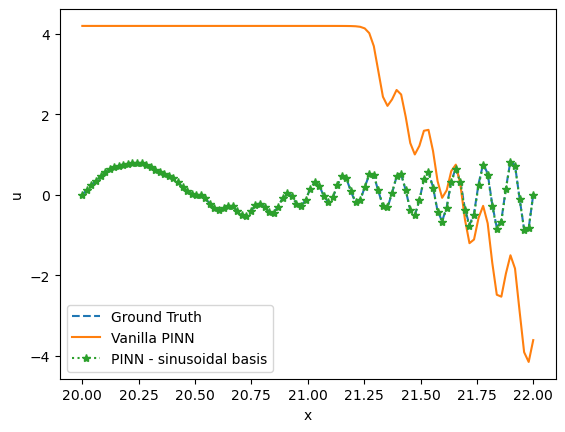

In [36]:
plt.plot(x,u,label="Ground Truth",linestyle="dashed")
plt.plot(x,ypreds,label= "Vanilla PINN")
plt.plot(x,ypreds_1,linestyle="dotted",label="PINN - sinusoidal basis",marker="*")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.savefig("sine_coupled.pdf",dpi=500)